# PACKAGES

In [1]:
import get_data as gd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import Asset as a
import numpy as np
import random
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [2]:
# Grab bitcoin data
df_data = gd.grab_data()

# HYPERPARAMETER

In [3]:
# set some hyperparameters
NUMBER_OF_GENERATION = 3
POPULATION_SIZE = 2000
CROSSOVER_PROBABILITY = 0.5
MUTATION_PROBABILITY = 0.3
HIGHEST_WINDOWSIZE = 30
LOWEST_WINDOWSIZE = 4
HIGHEST_HIGHTHRESHOLD = 90
LOWEST_HIGHRESHOLD = 70
HIGHEST_LOWTHRESHOLD = 30
LOWEST_LOWTHRESHOLD = 10
MUTATION_HIGH = 1.3
MUTATION_LOW = 0.7

#plotting hyperparams
N_COLS = 2
N_PLOTS = NUMBER_OF_GENERATION + 1
N_ROWS = (N_PLOTS + N_COLS - 1) // N_COLS

# TRADE STRATEGY

In [4]:
def apply_strategy(data, individual, start_time, end_time):
    # start_time is not allowed to be 0 because we need to know the close price yesterday
    if start_time <= 0:
        raise ValueError("start_time is not allowed to be 0 because we need to know the close price yesterday")
    
    # initialize some variables
    windowsize, highthreshold, lowthreshold = individual
    rsi = RSIIndicator(data["close"], window=windowsize)
    data["rsi"] = rsi.rsi()
    btc = np.asarray(data["close"])
    asset = a.Asset()
    in_position = False
    money_progress = []
    buy_days = []
    sell_days = []
    
    # apply buy and sell strategy
    for i in range(start_time - 1, end_time - 1):
        # buy
        if not in_position and data["rsi"].iloc[i] < lowthreshold:
            asset.buy(btc[i + 1])
            in_position = True
            buy_days.append(i)
        # sell
        elif in_position and data["rsi"].iloc[i] > highthreshold:
            asset.sell(btc[i + 1])
            in_position = False
            sell_days.append(i)
        # store the value of money in each iteration
        money_progress.append(asset.money + asset.coin * btc[i + 1])

    if in_position:
        asset.sell(btc[end_time])
        sell_days.append(end_time)

    money_progress.append(asset.money)

    btc_prices = btc[start_time:end_time + 1]
    return money_progress, btc_prices, buy_days, sell_days

# calculate fitness of each individual
def calculate_fitness(data, individual, start_time, end_time):
    money_progress, btc_prices, buy_days, sell_days = apply_strategy(data, individual, start_time, end_time)
    score = money_progress[-1]
    return score

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# calculate the probability of each individual and select them as the parents of next generation
def roulette_wheel_selection(population, fitness):
    softmax_fitness = softmax(fitness)
    selected_indices = np.random.choice(range(len(population)), size=2, replace=False, p=softmax_fitness)
    return [population[i] for i in selected_indices]

# PLOT

In [5]:
def draw_top_individuals(top_individuals, start_time, end_time, generation, is_test):
    # plot the money progress of the top 4 individuals in last generation
    color_list = ['r', 'b', 'g', 'k']
    subplot_location = generation // N_COLS,generation % N_COLS
    
    # plt.figure(figsize=(8, 4))
    for idx, (individual, fit) in enumerate(top_individuals[:4]):
        window, hight, lowt = individual
        days = range(start_time, end_time + 1)
        money_progress, btc_prices, buy_days, sell_days = apply_strategy(df_data, individual, start_time, end_time)
        
        # when it is test dataset
        if is_test:
            # Plot asset line
            axes[subplot_location].plot(days, money_progress, color=color_list[idx], label=f"Individual {idx + 1}")
            
            # Plot buy and sell points
            for buy_day in buy_days:
                axes[subplot_location].plot(buy_day, money_progress[buy_day - start_time], 'go', markersize=5)
            for sell_day in sell_days:
                axes[subplot_location].plot(sell_day, money_progress[sell_day - start_time], 'ro', markersize=5)
    
            # Plot the btc_prices
            ax2 = axes[subplot_location].twinx()
            ax2.plot(days, btc_prices, linestyle='--', color='orange', alpha=0.5, label='BTC Price (AUD)')
            ax2.set_ylabel("BTC Price (AUD)")
            
            # Add legend
            buy_marker = plt.Line2D([], [], color='g', marker='o', linestyle='None', markersize=5, label='Buy')
            sell_marker = plt.Line2D([], [], color='r', marker='o', linestyle='None', markersize=5, label='Sell')
            btc_price_line = plt.Line2D([], [], color='orange', linestyle='--', alpha=0.5, label='BTC Price (AUD)')
            axes[subplot_location].legend(handles=[buy_marker, sell_marker, btc_price_line], loc='best')
            
        else:
            axes[subplot_location].plot(days, money_progress, color=color_list[idx], 
                                    label=f"Individual {idx + 1}: | {window:02d} | {hight:03.2f} | {lowt:03.2f} |")
            axes[subplot_location].legend(loc='upper left')
            
    axes[subplot_location].set_title(f"Generation {generation + 1}" if generation != NUMBER_OF_GENERATION else 'Test Set')
    axes[subplot_location].set_xlabel("Day")
    axes[subplot_location].set_ylabel("Money(AUD)")
            
    
    # plt.savefig("figure/Top4IndividualsMoneyProgress.png")
    # plt.show()


# GENETIC ALGORITHM

In [6]:
def create_population(size):
    population = []
    # generate population by random parameters(genes)
    for _ in range(size):
        windowsize = random.randint(LOWEST_WINDOWSIZE, HIGHEST_WINDOWSIZE)
        highthreshold = random.uniform(LOWEST_HIGHRESHOLD, HIGHEST_HIGHTHRESHOLD)
        lowthreshold = random.uniform(LOWEST_LOWTHRESHOLD, HIGHEST_LOWTHRESHOLD)
        individual = (windowsize, highthreshold, lowthreshold)
        population.append(individual)
    return population

In [7]:
# crossover the parents to generate children
def crossover(parents):
    if random.random() < CROSSOVER_PROBABILITY:
        child1, child2 = parents
        crossover_point = random.randint(1, 2)
        child1 = child1[:crossover_point] + child2[crossover_point:]
        child2 = child2[:crossover_point] + child1[crossover_point:]
        return child1, child2
    else:
        return None, None

In [8]:
# mutate the children
def mutation(child):
    # set some variables about mutation
    mutation_prob = MUTATION_PROBABILITY
    mutated_gene_index = random.randint(0, 2)
    mutation_factor = random.uniform(MUTATION_LOW, MUTATION_HIGH)
    
    child = list(child)
    # if the random number is smaller than mutation probability, mutate the child
    if random.random() < mutation_prob:
        # mutate the gene by multiplying the mutation factor
        child[mutated_gene_index] *= mutation_factor
        # restrict the value of the gene
        if mutated_gene_index == 0:
            child[mutated_gene_index] = max(min(HIGHEST_WINDOWSIZE, int(child[mutated_gene_index])), LOWEST_WINDOWSIZE)
        elif mutated_gene_index == 1:
            child[mutated_gene_index] = max(min(HIGHEST_HIGHTHRESHOLD, child[mutated_gene_index]), LOWEST_HIGHRESHOLD)
        else:
            child[mutated_gene_index] = max(min(HIGHEST_LOWTHRESHOLD, child[mutated_gene_index]), LOWEST_LOWTHRESHOLD)

    return tuple(child)

In [9]:
def genetic_algorithm(data, start_time, end_time):
    # initialize the population
    population = create_population(POPULATION_SIZE)

    # run the algorithm for several generations
    for generation in range(NUMBER_OF_GENERATION):
        # calculate the fitness of each individual
        fitness = [calculate_fitness(data, individual, start_time, end_time) for individual in population]
        new_population = []

        # print the top 10 individuals and their fitness
        print('-' * 64)
        print(f"Generation {generation + 1}: Top 10 individuals and their fitness:")
        print('-' * 64)
        top_individuals = sorted(zip(population, fitness), key=lambda x: x[1], reverse=True)[:10]
        for individual, fit in top_individuals:
            window, hight, lowt = individual
            print(f"| {window:02d} | {hight:03.2f} | {lowt:03.2f} | Fitness: {fit:.2f}")
            
        draw_top_individuals(top_individuals, start_time, end_time, generation, False)

        # generate new population by crossover and mutation
        while len(new_population) < POPULATION_SIZE:
            parents = roulette_wheel_selection(population, fitness)
            child1, child2 = crossover(parents)
            if child1 and child2:
                child1 = mutation(child1)
                child2 = mutation(child2)
                new_population.extend([child1, child2])
            else:
                continue

        population = new_population
    
    # return the top 10 individuals
    return top_individuals

The day from  401  to  700 days.
----------------------------------------------------------------
Generation 1: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 05 | 78.70 | 26.06 | Fitness: 127.58
| 04 | 84.00 | 26.44 | Fitness: 125.86
| 04 | 72.92 | 27.70 | Fitness: 125.42
| 04 | 71.32 | 28.08 | Fitness: 125.42
| 04 | 71.67 | 25.02 | Fitness: 125.42
| 04 | 71.45 | 27.65 | Fitness: 125.42
| 04 | 82.66 | 28.57 | Fitness: 125.25
| 05 | 77.61 | 28.90 | Fitness: 124.83
| 04 | 73.34 | 25.91 | Fitness: 124.56
| 07 | 71.13 | 26.22 | Fitness: 122.89
----------------------------------------------------------------
Generation 2: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 05 | 78.70 | 29.66 | Fitness: 133.05
| 05 | 78.70 | 30.00 | Fitness: 133.05
| 05 | 78.70 | 30.00 | Fitness: 133.05
| 05 | 78.70 | 30.00 | Fitness: 133.05
| 05 | 78.70 | 30.00 | Fitness: 133.05
| 05 | 78.70 | 30.

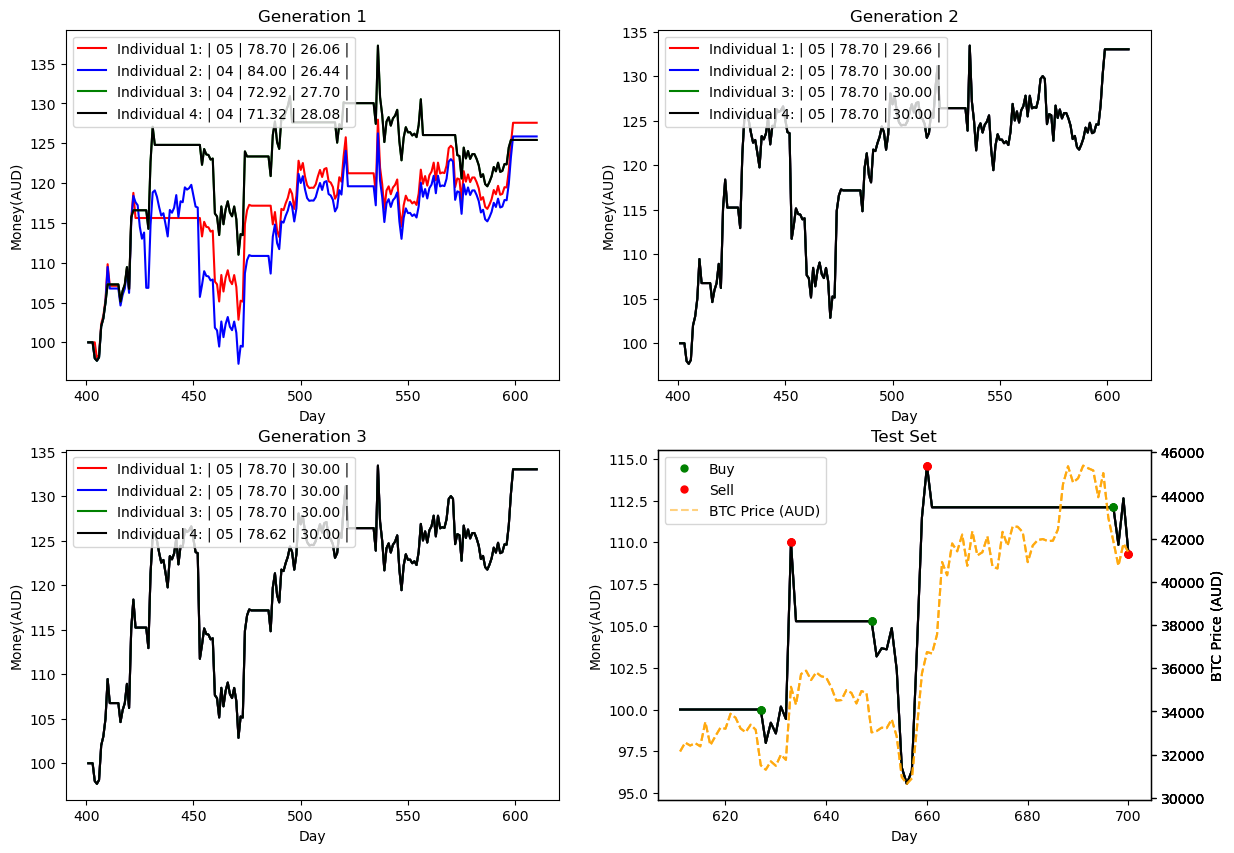




The day from  151  to  450 days.
----------------------------------------------------------------
Generation 1: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 11 | 71.81 | 21.42 | Fitness: 124.16
| 09 | 75.39 | 18.08 | Fitness: 124.16
| 11 | 71.32 | 20.06 | Fitness: 124.16
| 08 | 77.78 | 16.72 | Fitness: 124.16
| 11 | 71.32 | 21.73 | Fitness: 124.16
| 10 | 72.35 | 19.83 | Fitness: 124.16
| 06 | 85.06 | 12.06 | Fitness: 124.16
| 11 | 70.28 | 19.77 | Fitness: 123.74
| 05 | 88.27 | 10.10 | Fitness: 123.74
| 07 | 79.53 | 13.80 | Fitness: 123.74
----------------------------------------------------------------
Generation 2: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 11 | 71.81 | 21.42 | Fitness: 124.16
| 11 | 71.81 | 21.42 | Fitness: 124.16
| 08 | 77.78 | 16.72 | Fitness: 124.16
| 09 | 75.39 | 18.08 | Fitness: 124.16
| 11 | 71.32 | 21.73 | Fitness: 124.16
| 11 | 71.32 | 

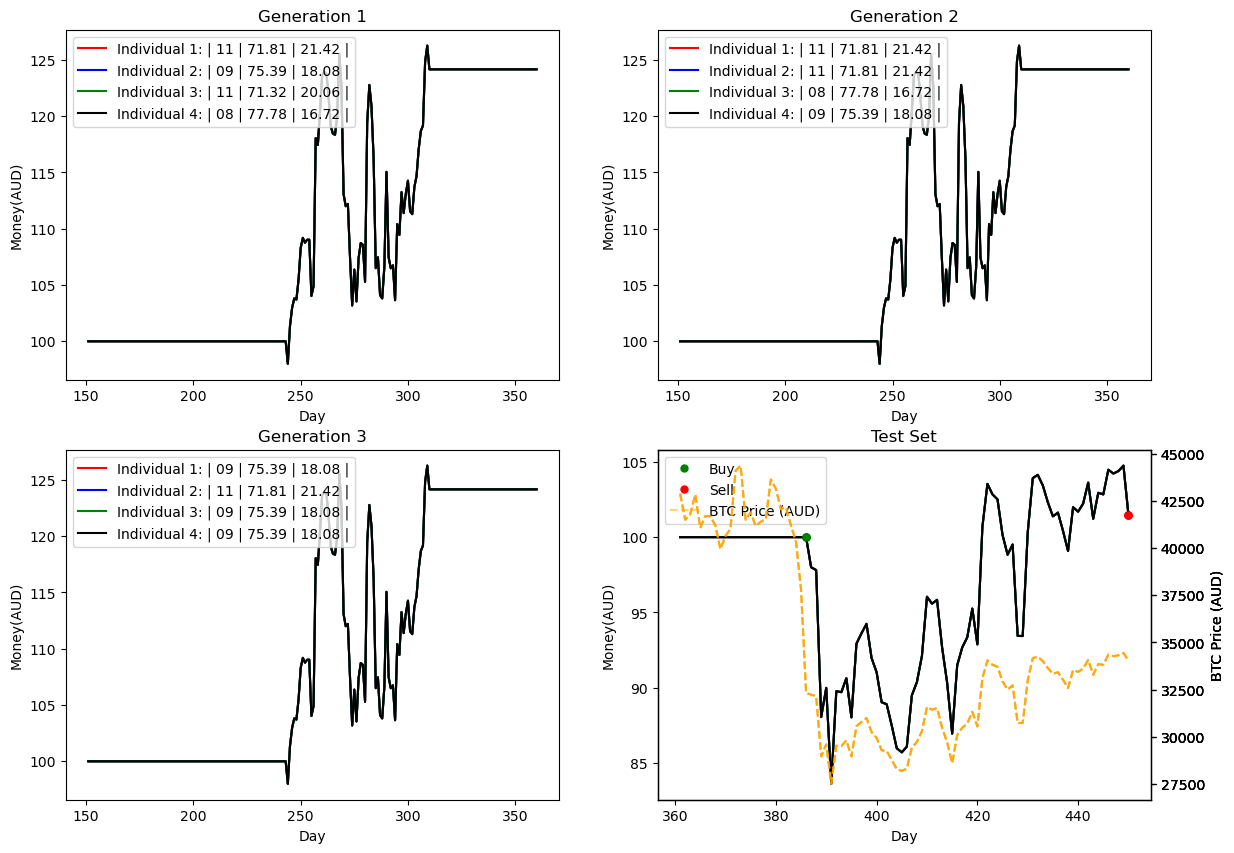

In [10]:
train_start_time_list = [401, 151]
train_end_time_list = [610, 360]
test_end_time_list = [700, 450]

for i in range(0, 2):
    train_start_time = train_start_time_list[i]
    train_end_time = train_end_time_list[i]
    test_start_time = train_end_time_list[i] + 1
    test_end_time = test_end_time_list[i]
    
    #subplot init
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(14, 10))
    
    print('The day from ', train_start_time, ' to ', test_end_time, 'days.')
    #train
    #print('------------------------train---------------------------')
    top_individuals = genetic_algorithm(df_data, train_start_time, train_end_time)
    # test
    #print('------------------------test---------------------------')
    draw_top_individuals(top_individuals, test_start_time, test_end_time, NUMBER_OF_GENERATION, True)
    plt.savefig(f"figure/{train_start_time}to{test_end_time}")
    plt.show()
    print()
    print()
    print()